In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

## (1, 28, 28)  ->  (128, 1, 1)

In [2]:
ZDIM = 4            # latent dimension

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_channels=1, out_channels=128):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=5, stride=2, padding=2)       # (1, 28, 28) -> (64, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=2)                # (64, 14, 14) -> (128, 7, 7)
        self.fc1 = nn.Linear(6272, 2 * ZDIM)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, start_dim=1)         # input image has 4 dimensions. but we want to flatten c,h,w. not the batch dimension. so start dim = 1
        x = self.fc1(x)
        
        return x

In [4]:
encoder = Encoder(in_channels=1, out_channels=128)

In [5]:
# rand_img = np.random.rand(1, 28, 28)
# rand_img = rand_img.astype(np.float32)

rand_img = torch.rand(1, 28, 28)
rand_img = torch.unsqueeze(rand_img, dim=0)
pred = encoder(rand_img)
print(pred.shape)

torch.Size([1, 8])


## (64, 1, 1)  ->  (1, 28, 28)

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(ZDIM, 6272)
        self.conv1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)       # (128, 7, 7) -> (64, 14, 14)
        self.conv2 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=2, stride=2)        # (64, 14, 14) -> (1, 28, 28)

    def forward(self, x):
        B, D = x.shape
        x = self.fc1(x)
        x = F.relu(x)
        x = x.reshape(B, 128, 7, 7)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        
        return x

In [7]:
decoder = Decoder()

In [8]:
# rand_img2 = np.random.rand(64, 1, 1)
# rand_img2 = rand_img2.astype(np.float32)

rand_img2 = torch.rand(ZDIM)
# rand_img2 = torch.from_numpy(rand_img2)
rand_img2 = torch.unsqueeze(rand_img2, dim=0)
pred2 = decoder(rand_img2)
print(pred2.shape)

torch.Size([1, 1, 28, 28])


## MNIST

In [9]:
train_path = "/kaggle/input/digit-recognizer/train.csv"
test_path = "/kaggle/input/digit-recognizer/test.csv"

In [10]:
train_df = pd.read_csv(train_path)
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
test_df = pd.read_csv(test_path)
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
train_data = train_df.values
X_train = train_data[:, 1:]
y_train = train_data[:, 0]
print(train_data)

test_data = test_df.values

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [7 0 0 ... 0 0 0]
 [6 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]]


In [13]:
X_train.max()

255

In [14]:
print(train_data.shape)
print(test_data.shape)

(42000, 785)
(28000, 784)


(28, 28)


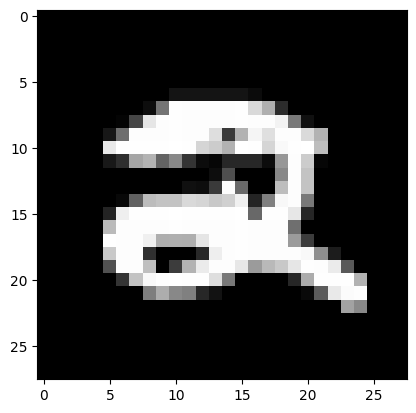

In [15]:
import matplotlib.pyplot as plt
from PIL import Image

ex_idx = 643
img = X_train[ex_idx]
img = img.reshape(28,28)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [16]:
class MNIST(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        image = torch.tensor(self.x[idx])

        image = image/255
        image = (image*2) - 1
        image = image.float()
        image = image.reshape(1,28,28)
        if self.y is None:
            return image
        
        label = torch.tensor(self.y[idx])
        
        return image, label

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
train_dataset = MNIST(X_train, y_train)
val_dataset = MNIST(X_val, y_val)
test_dataset = MNIST(test_data)

In [19]:
train_dataset[420][0].shape

torch.Size([1, 28, 28])

In [20]:
LR = 0.003
BATCH_SIZE = 128
EPOCHS = 20

In [21]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

## Training

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
encoder.to(device)
decoder.to(device)

Decoder(
  (fc1): Linear(in_features=4, out_features=6272, bias=True)
  (conv1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv2): ConvTranspose2d(64, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [24]:
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=LR)

In [25]:
from tqdm.auto import tqdm

for epoch in tqdm(range(EPOCHS)):
    for batch in train_loader:
    
        images, labels = batch
        images = images.to(device)
        mu_logvar = encoder(images)
        
        mu = mu_logvar[:, :ZDIM]
        log_var = mu_logvar[:, ZDIM:]
        
        var = torch.exp(log_var)
        sigma = torch.sqrt(var)
        epsilon = torch.randn_like(sigma)      # sigma je shape ar je device e ache, shetar alike
        z = mu + sigma * epsilon
        
        pred = decoder(z)
        
        #    ~ Losses ~
        # Reconstruction Loss
        recon_loss = F.mse_loss(pred, images)*28*28
        
        # KL Divergence
        kl_div = - 0.5 * torch.mean(torch.sum(1 + log_var - mu**2 - var, dim=1))
        
        loss = recon_loss + kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

  0%|          | 0/20 [00:00<?, ?it/s]

## Generation

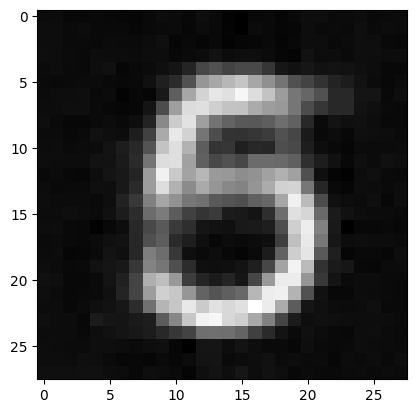

In [26]:
latent = torch.randn(ZDIM)
latent = torch.unsqueeze(latent, dim=0).to(device)

with torch.no_grad():
    pred = decoder(latent)
pred = torch.squeeze(pred, dim=0).to("cpu")
plt.imshow(pred[0], cmap='gray')
plt.show()